# Generative model of Labels, Abilities, and Difficulties (GLAD)

В [семинаре 15](https://github.com/esokolov/ml-course-hse/blob/master/2020-spring/seminars/sem15-em.pdf) мы рассмотрели задачу восстановления истинной разметки по меткам от экспертов (которым мы не можем доверять в полной мере, более того, их предсказания могут расходиться).

Рассмотрим следующую вероятностную модель:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

где $l_{ij} -$ ответ $j$-го эксперта на задачу $i$, $z_j -$ истинная разметка, $\alpha_j, \beta_i-$ уровень экспертизы и сложность задачи соответственно. Для более подробного описания модели можно прочитать материалы семинара, а также [оригинальную статью](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [1]:
import numpy as np
seed = 0xDEADF00D
np.random.seed(seed)

In [2]:
L = np.load('L.npy')
n, m = L.shape
print(f"Число задач (n_problems): {n}, число экспертов (n_experts): {m}")

Число задач (n_problems): 2000, число экспертов (n_experts): 20


Цель EM-алгоритма --- максимизация правододобия параметров. Но значения скрытых переменных неизвестны, поэтому посчитать правдоподобие нельзя. Поэтому EM-алгоритм максимизирует не само правдоподобие, а его матожидание.

## E-шаг

### Апостериорное распределение скрытых переменных

Полное правдободобие параметров $\alpha,\beta$ на $i$-ой задаче:
$$
p(z_i, l_i\,|\,\alpha, \beta_i)=p(z_i)\prod_j\left(\sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{[l_{ij}\neq z_i]}\right)
$$

Используя это, можно посчитать апостериорное распределение скрытых переменных (E-шаг):
$$
q_i^*(z_i)=p(z_i\,|\, l_i,\alpha,\beta_i)={p(z_i,l_i\,|\,\alpha,\beta_i)\over p(0,l_i\,|\,\alpha,\beta_i)+p(1,l_i\,|\,\alpha,\beta_i)}.
$$

При этом
$$
q_i^*(0)={1\over1+{p(1,l_i\,|\,\alpha,\beta_i)\over p(0,l_i\,|\,\alpha,\beta_i)}},\quad q_i^*(1)={1\over1+{p(0,l_i\,|\,\alpha,\beta_i)\over p(1,l_i\,|\,\alpha,\beta_i)}}.
$$

Распишем подробнее отношение вероятностей:
$$
{p(z_i=1,l_i\,|\,\alpha,\beta_i)\over p(z_i=0,l_i\,|\,\alpha,\beta_i)}=\prod_j{\sigma(\alpha_j\beta_i)^{[l_{ij}=1]}\sigma(-\alpha_j\beta_i)^{[l_{ij}=0]}\over \sigma(\alpha_j\beta_i)^{[l_{ij}=0]}\sigma(-\alpha_j\beta_i)^{[l_{ij}=1]}}=\prod_j \sigma(\alpha_j\beta_i)^{[l_{ij}=1]-[l_{ij}=0]}\sigma(-\alpha_j\beta_i)^{[l_{ij}=0]-[l_{ij}=1]}
$$
Выражение $\tilde l_{ij}=[l_{ij}=1]-[l_{ij}=0]$ принимает только значения $\pm1$.
$$
{p(z_i=1,l_i\,|\,\alpha,\beta_i)\over p(z_i=0,l_i\,|\,\alpha,\beta_i)}=\prod_j\left({\sigma(\alpha_j\beta_i)\over \sigma(-\alpha_j\beta_i)}\right)^{\tilde l_{ij}}=\prod_j \exp(\tilde l_{ij}\alpha_j\beta_i)=\exp\left(\sum_j\tilde l_{ij}\alpha_j\beta_i\right).
$$
Всё благодаря замечательному свойству сигмоиды:
$$
{\sigma(x)\over \sigma(-x)}={\sigma(x)\over 1-\sigma(x)}={{1\over 1+e^{-x}}\over1-{1\over 1+e^{-x}}}=e^x.
$$
Это приводит нас к элегантному виду апостериорного распределения:
$$
q_i^*(0)=p(z_i=0,l_i\,|\,\alpha,\beta_i)={1\over1+\exp\left(\sum_j\tilde l_{ij}\alpha_j\beta_i\right)}=\sigma\left(-\beta_i\sum_j\tilde l_{ij}\alpha_j\right).
$$
А вероятность $z_i=1$ равна $1-q_i^*(0)$.


### Мат. ожидание логарифма правдоподобия

С помощью апостериорного распределения скрытых переменных можем посчитать expectation of log likelihood:
$$
\mathbb{E}_{q^*}\log p(z,l\,|\,\alpha,\beta)=\sum_{i,j}\sum_{t\in\{0,1\}}q_i^*(t)\left([l_{ij}=t]\log\sigma(\alpha_j\beta_i)+[l_{ij}\neq t]\log\sigma(-\alpha_j\beta_i)\right)+C.
$$

Константа $C$ зависит только от $p(z_i)$.

Подставим $[l_{ij}\neq t]=1-[l_{ij}=t]$ в круглые скобки. Получим:
$$
[l_{ij}=t]\left(\log\sigma(\alpha_j\beta_i)-\log\sigma(-\alpha_j\beta_i\right)+\log\sigma(-\alpha_j\beta_i).
$$
В силу замечательного свойства сигмоиды получим
$$
[l_{ij}=t]\alpha_j\beta_i+\log\sigma(-\alpha_j\beta_i).
$$
Распишем суммирование по $t\in\{0,1\}$:
$$
q_i^*(0)\left([l_{ij}=0]\alpha_j\beta_i+\log\sigma(-\alpha_j\beta_i)\right)+q_i^*(1)\left([l_{ij}=1]\alpha_j\beta_i+\log\sigma(-\alpha_j\beta_i)\right).
$$
Применяя те же самые приемы, получим:
$$
\mathbb{E}_{q^*}\log p(z,l\,|\,\alpha,\beta)=\sum_{ij}\log\sigma(-\alpha_j\beta_i)+\alpha_j\beta_i\left[-q_i^*(0)\tilde l_{ij}+l_{ij}\right]+C
$$

## M-шаг

### Градиент по $\alpha$

M-шаг реализуем с помощью градиентного подъёма.
$$
{\partial\over\partial\alpha_j}\mathbb{E}_{q^*}\log p(z,l\,|\,\alpha,\beta)=\sum_i\sum_{t\in\{0,1\}}q_i^*(t)\beta_i\left([l_{ij}=t]\sigma(-\alpha_j\beta_i)-[l_{ij}\neq t]\sigma(\alpha_j\beta_i)\right).
$$
Подставим $\sigma(-\alpha_j\beta_i)=1-\sigma(\alpha_j\beta_i)$ в круглые скобки. Получим:
$$
[l_{ij}=t]-\sigma(\alpha_j\beta_i).
$$
Распишем суммирование по $t\in\{0,1\}$:
$$
q_i^*(0)\beta_i\left([l_{ij}=0]-\sigma(\alpha_j\beta_i)\right)+q_i^*(1)\beta_i\left([l_{ij}=1]-\sigma(\alpha_j\beta_i)\right)=\beta_i\left(q_i^*(0)[l_{ij}=0]+q_i^*(1)[l_{ij}=1]-\sigma(\alpha_j\beta_i)\right)
$$
Подставим $q_i^*(1)=1-q_i^*(0)$. Получим:
$$
q_i^*(0)\left([l_{ij}=0]-[l_{ij}=1]\right)+[l_{ij}=1]=-q_i^*(0)\cdot\tilde l_{ij}+l_{ij}
$$
Итоговое выражение для частной производной:
$$
{\partial\over\partial\alpha_j}\mathbb{E}_{q^*}\log p(z,l\,|\,\alpha,\beta)=\sum_i\beta_i\left(-q_i^*(0)\cdot\tilde l_{ij}+l_{ij}-\sigma(\alpha_j\beta_i)\right).
$$



### Градиент по $\beta$

Производная для $\beta$
$$
{\partial\over\partial\beta_i}\mathbb{E}_{q^*}\log p(z,l\,|\,\alpha,\beta)=\sum_j\sum_{t\in\{0,1\}}q_i^*(t)\alpha_j\left([l_{ij}=t]\sigma(-\alpha_j\beta_i)-[l_{ij}\neq t]\sigma(\alpha_j\beta_i)\right).
$$

Аналогичные преобразования дают:
$$
{\partial\over\partial\beta_i}\mathbb{E}_{q^*}\log p(z,l\,|\,\alpha,\beta)=\sum_j\alpha_j\left(-q_i^*(0)\tilde l_{ij}+l_{ij}-\sigma(\alpha_j\beta_i)\right).
$$

## Check Gradients

**Подсказка:**
* При проверке alpha значения, выдываемые функцией `check_grad` должны быть не более 0.01. Иначе у вас где-то ошибка
* При проверке logbeta значения, выдываемые функцией `check_grad` должны быть не более 0.05. Иначе у вас где-то ошибка

In [3]:
from scipy.optimize import check_grad
from glad import GLAD


alpha = np.random.randn(m)
logbeta = np.random.randn(n)
beta = np.exp(logbeta)

q = np.ones((len(beta), 1))

obj = GLAD()
obj.L = L
obj.L_tilde = 2 * L - 1

In [4]:
check_grad(
    lambda a: obj._lower_bound(q, a, beta),
    lambda a: obj._grads(q, a, beta).alpha,
    alpha
)

0.001508132009454201

In [5]:
check_grad(
    lambda b: obj._lower_bound(q, alpha, np.exp(b)),
    lambda b: obj._grads(q, alpha, np.exp(b)).logbeta,
    logbeta
)

0.011115194079907034

## Check EM-algorithm

In [6]:
y = np.load('y.npy')
obj = GLAD(n_outer_steps=10000)
alphas, betas, log_like, acc = obj.fit(L, y)

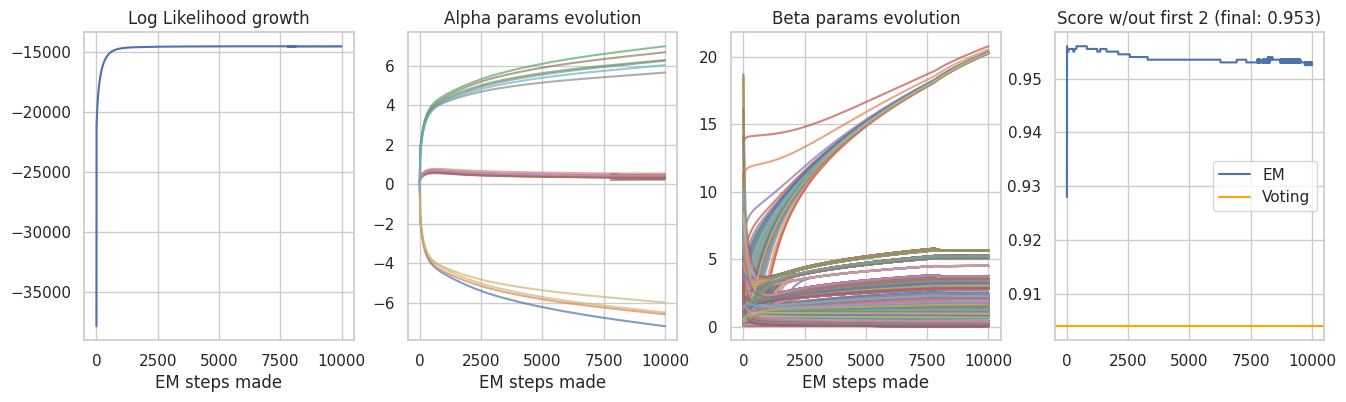

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid')

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].plot(log_like)
ax[1].plot(alphas, alpha=0.7)
ax[2].plot(betas, alpha=0.7)
t = 2
ax[3].plot(acc[t:], label='EM')
# produce labels by simple voting
ax[3].axhline(
    np.mean((np.mean(L, axis=1) > 0.5) == y),
    color='orange', label='Voting'
)
ax[3].legend()

ax[0].set_title('Log Likelihood growth')
ax[1].set_title('Alpha params evolution')
ax[2].set_title('Beta params evolution')
ax[3].set_title(f'Score w/out first {t} (final: {acc[-1]:.3f})')

ax[0].set_xlabel('EM steps made')
ax[1].set_xlabel('EM steps made')
ax[2].set_xlabel('EM steps made')

plt.show()

In [8]:
print('voting accuracy:', np.mean((np.mean(L, axis=1) > 0.5) == y))

ans = np.mean((obj.q > 0.5) != y[:, None]) 
if ans < 0.5:
  ans = np.mean((obj.q > 0.5) == y[:, None]) 
print('EM accuracy:', ans)

voting accuracy: 0.904
EM accuracy: 0.9525


In [9]:
obj = GLAD(n_outer_steps=100)
alphas, betas, log_like, acc = obj.fit(L, y)

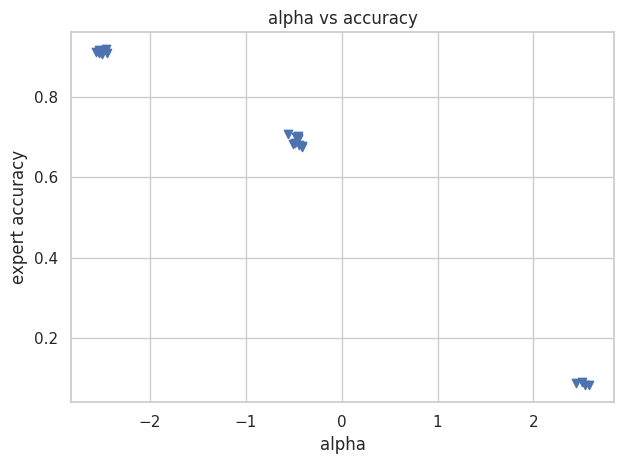

In [10]:
accs = (L == y[:, None]).mean(axis=0)

plt.scatter(obj.alpha, accs, marker='v')
plt.xlabel('alpha')
plt.ylabel('expert accuracy')
plt.title('alpha vs accuracy')
plt.tight_layout()

**Выводы:** видим, что важно лишь абсолютное значение альфы, т.к.
- при альфа близком к нулю эксперт плохо разделяет классы
- при большом положительном альфа эксперт хорошо раздялет классы и размечает "наоборот"
- при большом отрицательном альфа эксперт хорошо разделяет классы и размечает правильно